In [ ]:
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install scikit-learn

ERROR: You must give at least one requirement to install (see "pip help install")


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
from sklearn.pipeline import make_pipeline

# Step 1: Set the path to your dataset
data_dir = '/content/test.zip'  # Update this to your actual dataset path
extract_dir = '/content/test'
categories = ['cats', 'dogs']

# Extract the dataset from zip file
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Step 2: Update the data directory to the extracted location
data_dir = extract_dir  # Now points to the extracted directory

# Load and preprocess the data
images = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (128, 128))  # Resize to 128x128
        images.append(image)
        labels.append(categories.index(category))  # 0 for cats, 1 for dogs

images = np.array(images)
labels = np.array(labels)

# Step 3: Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Step 4: Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Flatten the images for SVM
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Step 5: Data Augmentation
augmented_images = []
augmented_labels = []

for img, label in zip(X_train, y_train):
    img = img.reshape(128, 128, 3)  # Reshape to original dimensions
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Generate augmented images
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)  # Keep the label same
        if len(augmented_images) >= len(X_train):  # Create as many as original dataset
            break

# Convert lists to numpy arrays
X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)

# Step 6: Feature Scaling
scaler = StandardScaler()
X_train_augmented = scaler.fit_transform(X_train_augmented.reshape(X_train_augmented.shape[0], -1))
X_test = scaler.transform(X_test)

# Step 7: Hyperparameter Tuning with Grid Search
# Create a pipeline with SVC
pipeline = make_pipeline(StandardScaler(), SVC())

# Define parameter grid for SVM
param_grid = {
    'svc__kernel': ['linear', 'rbf'],  # Test linear and RBF kernels
    'svc__C': [0.1, 1, 10],  # Different values of C
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_augmented, y_train_augmented)

print(f"Best parameters: {grid_search.best_params_}")

# Step 8: Train the best SVM model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_augmented, y_train_augmented)

# Step 9: Evaluate the Model
y_pred = best_svm_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'svc__C': 0.1, 'svc__kernel': 'rbf'}
Confusion Matrix:
[[14  0]
 [14  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        14
           1       0.00      0.00      0.00        14

    accuracy                           0.50        28
   macro avg       0.25      0.50      0.33        28
weighted avg       0.25      0.50      0.33        28



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters: {'svc__C': 1, 'svc__kernel': 'rbf'}


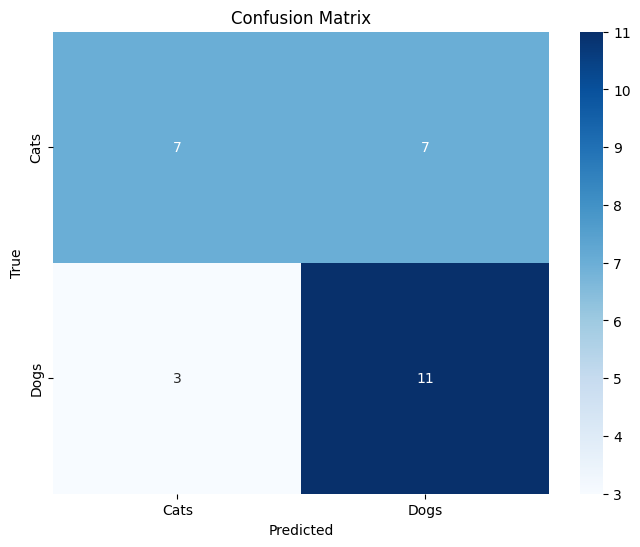

Confusion Matrix:
[[ 7  7]
 [ 3 11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        14
           1       0.61      0.79      0.69        14

    accuracy                           0.64        28
   macro avg       0.66      0.64      0.64        28
weighted avg       0.66      0.64      0.64        28



In [ ]:
import os
import numpy as np
import cv2
from skimage.feature import hog
from skimage.color import rgb2gray  # Import rgb2gray
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import zipfile
from sklearn.pipeline import make_pipeline

# Step 1: Set the path to your dataset
data_dir = '/content/test.zip'  # Update this to your actual dataset path
extract_dir = '/content/test'
categories = ['cats', 'dogs']

# Extract the dataset from zip file
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Step 2: Update the data directory to the extracted location
data_dir = extract_dir  # Now points to the extracted directory

# Load and preprocess the data
images = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (128, 128))  # Resize to 128x128
        images.append(image)
        labels.append(categories.index(category))  # 0 for cats, 1 for dogs

images = np.array(images)
labels = np.array(labels)

# Step 3: Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Step 4: Feature Extraction using HOG
def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray_img = rgb2gray(img)
        features = hog(gray_img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

# Step 6: Hyperparameter Tuning with Grid Search
# Create a pipeline with SVC
pipeline = make_pipeline(StandardScaler(), SVC())

# Define parameter grid for SVM
param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly'],  # Include polynomial kernel
    'svc__C': [0.1, 1, 10, 100],  # Different values of C for better tuning
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_hog, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# Step 7: Train the best SVM model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_hog, y_train)

# Step 8: Evaluate the Model
y_pred = best_svm_model.predict(X_test_hog)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cats', 'Dogs'], yticklabels=['Cats', 'Dogs'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
